# **Aprendizado Supervisionado - Segmentação Semântica**

Importando as Bibliotecas Necessárias





In [ ]:
!pip3 install -U segmentation-models

In [1]:
%env SM_FRAMEWORK=tf.keras

import segmentation_models as sm
import tensorflow as tf
from segmentation_models.utils import set_trainable
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD
#from model import *
#from data import *
import numpy as np 
import os
import glob
import skimage.io as io
import skimage.transform as trans
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, CSVLogger

env: SM_FRAMEWORK=tf.keras


2023-02-21 14:41:04.130405: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-21 14:41:04.315401: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-21 14:41:04.353558: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-21 14:41:04.353586: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

Segmentation Models: using `tf.keras` framework.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Extraindo e colocando o dataset na pasta /tmp

In [ ]:
!cp /content/drive/MyDrive/jupiter/dataset_intcomp.zip  /tmp

In [ ]:
import os
import zipfile

local_zip = '/tmp/dataset_intcomp.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/')
zip_ref.close()

In [ ]:
def adjust_data(img,mask,flag_multi_class,num_class):
    if(flag_multi_class):
        img = img / 255
        mask = mask[:,:,:,0] if(len(mask.shape) == 4) else mask[:,:,0]
        new_mask = np.zeros(mask.shape + (num_class,))
        for i in range(num_class):
            new_mask[mask == i,i] = 1
        new_mask = np.reshape(new_mask,(new_mask.shape[0],new_mask.shape[1]*new_mask.shape[2],new_mask.shape[3])) if flag_multi_class else np.reshape(new_mask,(new_mask.shape[0]*new_mask.shape[1],new_mask.shape[2]))
        mask = new_mask
    elif(np.max(img) > 1):
        img = img / 255
        mask = mask /255
        mask[mask >= 0.5] = 1
        mask[mask < 0.5] = 0
    return (img,mask)

In [ ]:
def train_generator(batch_size, 
                   train_path,
                   image_folder,
                   mask_folder,
                   aug_dict,
                   image_color_mode = "grayscale",
                   mask_color_mode = "grayscale", 
                   image_save_prefix  = "image", 
                   mask_save_prefix  = "mask",
                   flag_multi_class = False,
                   num_class = 1,
                   save_to_dir = None,
                   target_size = (1024,1024),
                   seed = 1):
    '''
    Can generate image and mask at the same time. Use the same seed for image_datagen and mask_datagen to ensure 
    the transformation for image and mask is the same. If you want to visualize the results of generator, set 
    save_to_dir = "your path"
    '''
    
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_directory(train_path,
                                                        classes = [image_folder],
                                                        class_mode = None,
                                                        color_mode = image_color_mode,
                                                        target_size = target_size,
                                                        batch_size = batch_size,
                                                        save_to_dir = save_to_dir,
                                                        save_prefix  = image_save_prefix,
                                                        seed = seed)
    
    mask_generator = mask_datagen.flow_from_directory(train_path,
                                                        classes = [mask_folder],
                                                        class_mode = None,
                                                        color_mode = mask_color_mode,
                                                        target_size = target_size,
                                                        batch_size = batch_size,
                                                        save_to_dir = None,
                                                        save_prefix  = mask_save_prefix,
                                                        seed = seed)
    
    train_generator = zip(image_generator, mask_generator)
    
    for (img,mask) in train_generator:
        img,mask = adjust_data(img, mask, flag_multi_class, num_class)
        yield (img,mask)

In [ ]:
def test_generator(batch_size,
                  test_path,
                  image_folder,
                  mask_folder,
                  image_color_mode = "grayscale",
                  mask_color_mode = "grayscale",
                  image_save_prefix  = "image",
                  mask_save_prefix  = "mask",
                  flag_multi_class = False,
                  num_class = 1, 
                  save_to_dir = None,
                  target_size = (1024,1024), seed = 2):
    '''
    Can generate image and mask at the same time. Use the same seed for image_datagen and mask_datagen to ensure 
    the transformation for image and mask is the same. If you want to visualize the results of generator, set 
    save_to_dir = "your path"
    '''
    
    image_datagen = ImageDataGenerator()
    mask_datagen = ImageDataGenerator()
    
    image_generator = image_datagen.flow_from_directory(test_path,
                                                        classes = [image_folder],
                                                        class_mode = None,
                                                        color_mode = image_color_mode,
                                                        target_size = target_size,
                                                        batch_size = batch_size,
                                                        save_to_dir = save_to_dir,
                                                        save_prefix  = image_save_prefix,
                                                        seed = seed)
    
    mask_generator = mask_datagen.flow_from_directory(test_path,
                                                      classes = [mask_folder],
                                                      class_mode = None,
                                                      color_mode = mask_color_mode,
                                                      target_size = target_size,
                                                      batch_size = batch_size,
                                                      save_to_dir = save_to_dir,
                                                      save_prefix  = mask_save_prefix,
                                                      seed = seed)
    
    test_generator = zip(image_generator, mask_generator)
    
    for (img,mask) in test_generator:
        img,mask = adjust_data(img,mask,flag_multi_class,num_class)
        yield (img,mask)

Definindo como o Modelo fará o Data Augmentation

In [ ]:
data_gen_args = dict(rotation_range=180,
                    width_shift_range=0.07,
                    height_shift_range=0.07,
                    shear_range=0.07,
                    zoom_range=0.07,
                    horizontal_flip=True,
                    fill_mode='nearest')

Definindo o caminho das pastas de validação e treino. Inicializando o dimensionamento das imagens que serão lidas

In [ ]:
path_dataset = '/tmp'
train_data_path = '/tmp/train'
validation_data_path = '/tmp/validation' 

num_of_train_samples = sum(len(files) for _, _, files in os.walk(train_data_path))
num_of_validation_samples  = sum(len(files) for _, _, files in os.walk(validation_data_path))
print("Train Images : ", num_of_train_samples)
print("Validation Images  : ", num_of_validation_samples)

batch_size = 2
train_samples = num_of_train_samples
test_samples = num_of_validation_samples
steps_p_epoch = int(train_samples / batch_size)
val_steps = int(test_samples / batch_size)
nr_epochs = 1000

# Colocando a rede para treinar

In [ ]:
folds = 1

for nr_fold in range(0, folds):
    BACKBONE = 'vgg16'
    preprocess_input = sm.get_preprocessing(BACKBONE)

    trainGene = train_generator(batch_size, 
                               path_dataset, 
                               'train',
                               'mask_train',
                               data_gen_args,
                               save_to_dir = None, 
                               image_color_mode = "rgb"
                              )

    testGene = test_generator(batch_size, 
                              path_dataset,
                              'validation', 
                              'mask_validation', 
                              save_to_dir = None,
                              image_color_mode = "rgb")
    
    # define model
    DECODER = 'Linknet'
    #model = sm.Unet(backbone_name=BACKBONE,  encoder_weights='imagenet', encoder_freeze=True, classes=1, activation='sigmoid')
    model = sm.Linknet(backbone_name=BACKBONE, encoder_weights='imagenet', encoder_freeze=True, classes=1, activation='sigmoid')
    #model = sm.Linknet(backbone_name=BACKBONE, encoder_weights='imagenet', encoder_freeze=True, classes=1, activation='sigmoid', weights = '/tmp/vgg16_Linknet_Test28.hdf5')        
    opt = Adam(lr=1e-3)

    model.compile(opt,
                  loss=sm.losses.jaccard_loss,
                  metrics=[sm.metrics.IOUScore(threshold=0.5),
                  sm.metrics.FScore(threshold=0.5), 
                  sm.metrics.precision])

    csv_logger = CSVLogger(BACKBONE + "_" + DECODER + ".csv", append=True)
    
    model_checkpoint = ModelCheckpoint(BACKBONE + "_" + DECODER + "_" + str(nr_fold) + ".hdf5", 
                                       monitor='loss',
                                       verbose=1,
                                       save_best_only=True)
    
    history = model.fit(trainGene, 
                        validation_data = testGene,
                        validation_steps = val_steps,
                        steps_per_epoch = steps_p_epoch,
                        epochs=nr_epochs,
                        callbacks=[model_checkpoint, csv_logger])

In [ ]:
print(model.summary)

In [209]:
BACKBONE = 'vgg16'
model = sm.Linknet(backbone_name=BACKBONE, encoder_weights='imagenet', encoder_freeze=True, classes=1, activation='sigmoid', weights = './vgg16_Linknet.hdf5')

In [151]:
model = sm.Unet(backbone_name='resnet34', encoder_weights='imagenet', encoder_freeze=True, classes=1, activation='sigmoid', weights = './resnet34_Unet.hdf5')

In [60]:
def adjust_pixels(src, tolerancy):
        """
        funcao para ajustar os pixels com base em uma tolerancia, eliminando contornos com areas
        menores do que o valor escolhido para tolerancy
        entrada:
                 src       - imagem da predi
                 tolerancy - valor inteiro (0 despreza a tolerancia e retorna os contornos originais)
        saida:
                 result    - contornos validos com base no valor de tolerancy
        """
        ret, binary_map = cv2.threshold(src, 127, 255, 0)
        nlabels, labels, stats, centroids = cv2.connectedComponentsWithStats(
            binary_map, None, None, None, 8, cv2.CV_32S
        )

        areas = stats[1:, cv2.CC_STAT_AREA]
        result = np.zeros((labels.shape), np.uint8)

        for i in range(0, nlabels - 1):
            if areas[i] >= tolerancy:
                result[labels == i + 1] = 255

        return result

In [220]:
import cv2

img = cv2.imread('../dataset_insulators/test/test/images/41844.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (512, 512)) / 255

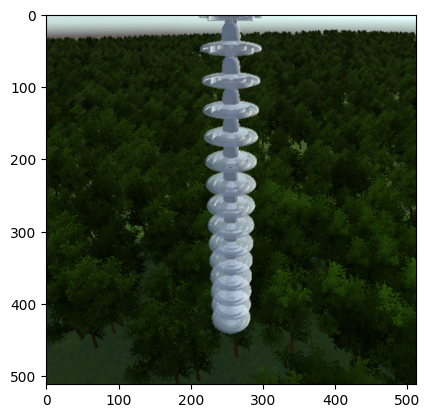

In [221]:
plt.imshow(img)
plt.show()

In [222]:
image_cp = img.copy()
pr = model.predict(np.array([image_cp]))[0]
pr = pr[:, :, 0]
pr[pr >= 0.9] = 1
pr[pr < 0.5] = 0

pr[pr == 1] = 255
#pr = adjust_pixels(pr.astype('uint8'), 70)

image_cp[pr == 255] = [255, 0, 0]

1/1 [==============================] - 1s 807ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


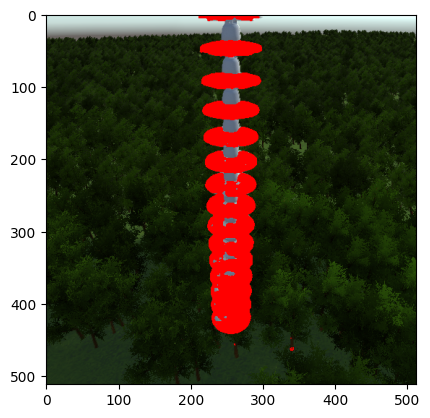

In [223]:
plt.imshow(image_cp)
plt.show()